In [61]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

In [62]:

TRAIN_DIR = "../../data/images/catdog/train_small/"
TEST_DIR = "../../data/images/catdog/test_small/"

# resizes the images to 256x256 
ROWS = 256
COLS = 256
ROWS2 = 64
COLS2 = 64
CHANNELS = 3

#train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [63]:
# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images =  train_cats[:100] + train_dogs[:100] #train_dogs[:10000] + train_cats[:10000]
random.shuffle(train_images)
test_images = test_images[1:100] #test_images[:1000]

In [82]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    b,g,r = cv2.split(img)
    img2 = cv2.merge([r,g,b])
    return cv2.resize(img2, (ROWS2, COLS2), interpolation=cv2.INTER_CUBIC)


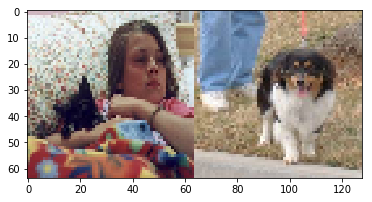

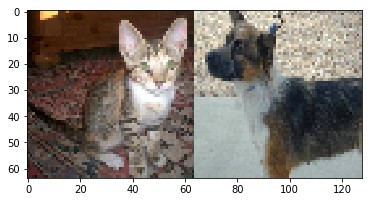

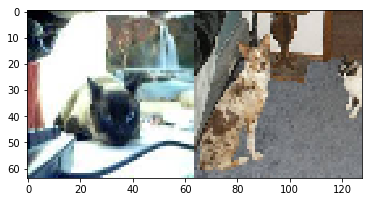

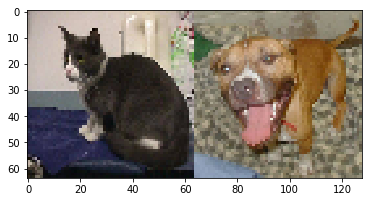

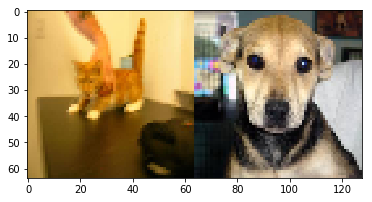

In [83]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

In [84]:

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS2, COLS2), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

#hot to delete .DS_Store files
#find . -name '.DS_Store' -type f -delete

Train shape: (28, 3, 64, 64)
Test shape: (27, 3, 64, 64)


[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0]


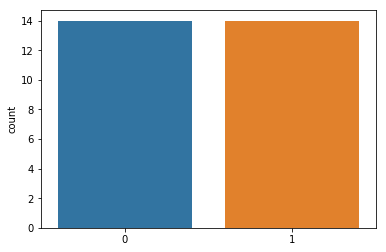

In [78]:
labels = []
for i in train_images:
    if 'dog.' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)
print(labels)

In [72]:
def catdog():
    
    model = Sequential()

    model.add(Conv2D(32, 3, padding='same', input_shape=train.shape[1:], activation='relu'))
    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #print("First layer...")
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #print("Second layer...")
    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #print("Third layer...")
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    #model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #print("Flattening, etc...")
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    print("Compiling model...")
    optimizer = RMSprop(lr=1e-4)
    objective = 'binary_crossentropy'
    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

print("Creating model:")
model = catdog()

Creating model:
Compiling model...


In [73]:
epochs = 20
batch_size = 16

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
       


In [85]:

history = LossHistory()
print("running model...")
model.fit(train, labels, batch_size=batch_size, epochs=epochs,
              validation_split=0.25, verbose=2, shuffle=True, callbacks=[history, early_stopping])
    
loss = history.losses
val_loss = history.val_losses


running model...
Train on 21 samples, validate on 7 samples
Epoch 1/20
 - 0s - loss: 0.6502 - acc: 0.7143 - val_loss: 0.6809 - val_acc: 0.4286
Epoch 2/20
 - 0s - loss: 0.5151 - acc: 0.7619 - val_loss: 0.6984 - val_acc: 0.4286
Epoch 3/20
 - 0s - loss: 0.6270 - acc: 0.6190 - val_loss: 0.7468 - val_acc: 0.4286
Epoch 4/20
 - 0s - loss: 0.9692 - acc: 0.5238 - val_loss: 0.6667 - val_acc: 0.5714
Epoch 5/20
 - 0s - loss: 0.7544 - acc: 0.5714 - val_loss: 0.6878 - val_acc: 0.4286
Epoch 6/20
 - 0s - loss: 0.5460 - acc: 0.6667 - val_loss: 0.6788 - val_acc: 0.5714
Epoch 7/20
 - 0s - loss: 0.6919 - acc: 0.6667 - val_loss: 0.6836 - val_acc: 0.4286
Epoch 00007: early stopping


In [86]:
print("making predictions on test set...")
predictions = model.predict(test, verbose=0)
  


making predictions on test set...


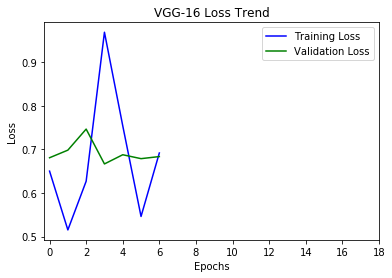

In [87]:


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

I am 58.97% sure this is a Cat


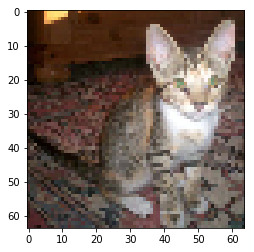

I am 63.90% sure this is a Cat


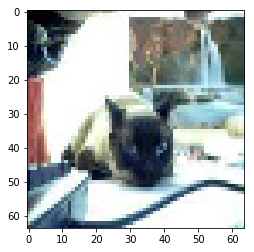

I am 59.17% sure this is a Cat


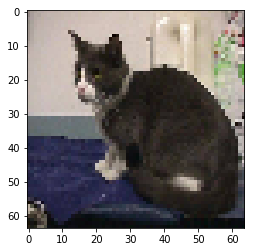

I am 59.31% sure this is a Cat


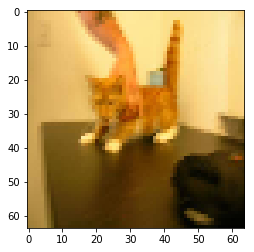

I am 50.81% sure this is a Cat


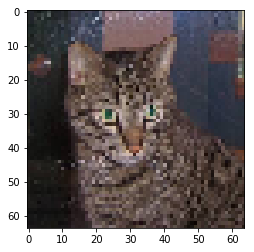

I am 58.35% sure this is a Cat


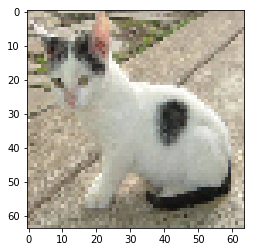

I am 54.52% sure this is a Cat


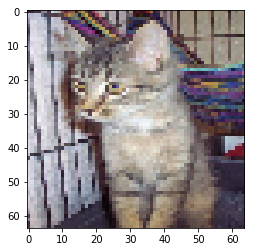

I am 51.78% sure this is a Dog


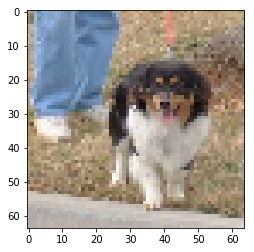

I am 55.65% sure this is a Dog


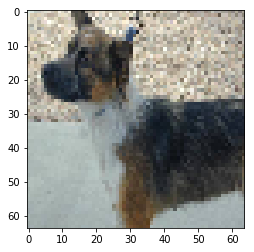

I am 51.69% sure this is a Dog


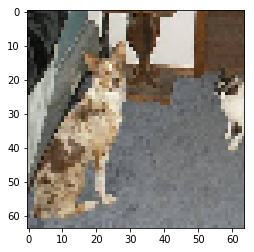

In [77]:

for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()